In [9]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
#import seaborn as sns; sns.set()

#------------------------------
#-- Read in Asset_Daily_View --
#------------------------------
df = pd.read_csv('BTC.csv')

#--------------------
#-- Pre-Processing --
#--------------------
# need to convert text to date
# ref code: raw_data['Mycol'] = pd.to_datetime(raw_data['Mycol'], format='%d%b%Y:%H:%M:%S.%f')

df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
df = df.set_index('Date') # need to have df = in the front... do I have to sort it?
df.sort_index(inplace=True)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1988 entries, 2013-04-28 to 2018-10-06
Data columns (total 6 columns):
Open          1988 non-null float64
High          1988 non-null float64
Low           1988 non-null float64
Close         1988 non-null float64
Volume        1988 non-null object
Market Cap    1988 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 108.7+ KB


In [3]:
df.describe()

,Open,High,Low,Close,Market Cap
count,1988.000000,1988.000000,1988.000000,1988.000000,1.988000e+03
mean,2185.557123,2254.474120,2108.753783,2188.595312,3.603724e+10
std,3427.456095,3556.683611,3270.362543,3428.306284,5.825479e+10
min,68.500000,74.560000,65.530000,68.430000,7.792550e+08
25%,313.635000,319.655000,301.615000,313.562500,4.267440e+09
50%,587.505000,597.525000,577.075000,587.790000,7.859760e+09
75%,2188.282500,2302.445000,2058.557500,2182.207500,3.579567e+10
max,19475.800000,20089.000000,18974.100000,19497.400000,3.261413e+11


In [4]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap'], dtype='object')

In [5]:
df.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,-,1500519936
2013-04-29,134.44,147.49,134.00,144.54,-,1491160064
2013-04-30,144.00,146.93,134.05,139.00,-,1597779968
2013-05-01,139.00,139.89,107.72,116.99,-,1542819968
2013-05-02,116.38,125.60,92.28,105.21,-,1292189952


In [6]:
#---------------------
#-- Set Time Window --
#---------------------
df = df.loc['20171216':]
df.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2017-12-16,17760.3,19716.7,17515.3,19497.4,12740599808,297375760384
2017-12-17,19475.8,20089.0,18974.1,19140.8,13314599936,326141280256
2017-12-18,19106.4,19371.0,18355.9,19114.2,14839499776,320000294912
2017-12-19,19118.3,19177.8,17275.4,17776.7,16894499840,320242253824
2017-12-20,17760.3,17934.7,16077.7,16624.6,22149699584,297526394880


In [7]:
#----------------------------------
#-- Strategy 1: Fixed Investment --
#----------------------------------
# may rewrite this as a function, input, output
# (use mod to implement fixed investment strategy)
# ref code: df['returns'] = np.log(df['closeAsk'] / df['closeAsk'].shift(1))  # 12
df['cons_date'] = pd.to_datetime("1900-01-01") # create a constant datetime series in pandas
df['date_diff'] = df['cons_date'] - df.index.to_series() # make it timedeltas

# if it is the 30th day, add position by 1 unit usd / current price
# mod date_diff by 30
df['pos_chg'] = (df['date_diff'].dt.days%30 == 0)*1/df['Close'] # to improve code, and better document
df.head()

,Open,High,Low,Close,Volume,Market Cap,cons_date,date_diff,pos_chg
Date,,,,,,,,,
2017-12-16,17760.3,19716.7,17515.3,19497.4,12740599808,297375760384,1900-01-01,-43083 days,0.0
2017-12-17,19475.8,20089.0,18974.1,19140.8,13314599936,326141280256,1900-01-01,-43084 days,0.0
2017-12-18,19106.4,19371.0,18355.9,19114.2,14839499776,320000294912,1900-01-01,-43085 days,0.0
2017-12-19,19118.3,19177.8,17275.4,17776.7,16894499840,320242253824,1900-01-01,-43086 days,0.0
2017-12-20,17760.3,17934.7,16077.7,16624.6,22149699584,297526394880,1900-01-01,-43087 days,0.0


In [8]:
#--------------------------
#--- Strategy 1: CumSum  --
#--------------------------
# pct_return = market_value / cum_cost - 1
# market_value = cum_pos * current_price
# cost = pos * price
# cum_cost = cum(cost)
# ref code: 
#   df[strats].dropna().cumsum().apply(np.exp).plot()  # 24
df['cum_pos'] = df['pos_chg'].cumsum()
df['cost'] = df['pos_chg']*df['Close']
df['market_value'] = df['cum_pos']*df['Close']
df['cum_cost'] = df['cost'].cumsum()
df['pct_return'] = df['market_value']/df['cum_cost'] - 1
df.head()

,Open,High,Low,Close,Volume,Market Cap,cons_date,date_diff,pos_chg,cum_pos,cost,market_value,cum_cost,pct_return
Date,,,,,,,,,,,,,,
2017-12-16,17760.3,19716.7,17515.3,19497.4,12740599808,297375760384,1900-01-01,-43083 days,0.0,0.0,0.0,0.0,0.0,NaN
2017-12-17,19475.8,20089.0,18974.1,19140.8,13314599936,326141280256,1900-01-01,-43084 days,0.0,0.0,0.0,0.0,0.0,NaN
2017-12-18,19106.4,19371.0,18355.9,19114.2,14839499776,320000294912,1900-01-01,-43085 days,0.0,0.0,0.0,0.0,0.0,NaN
2017-12-19,19118.3,19177.8,17275.4,17776.7,16894499840,320242253824,1900-01-01,-43086 days,0.0,0.0,0.0,0.0,0.0,NaN
2017-12-20,17760.3,17934.7,16077.7,16624.6,22149699584,297526394880,1900-01-01,-43087 days,0.0,0.0,0.0,0.0,0.0,NaN


/Users/jzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/jzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/jzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

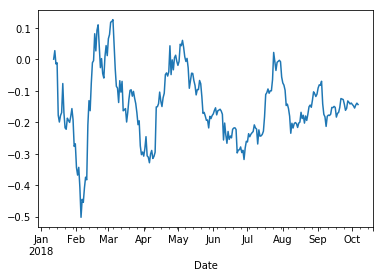

In [24]:
df['pct_return'].plot()
plt.show()

#----------------------
#--- Merge then Plot --
#----------------------

# Write csv
df.to_csv('out.csv')